###### Initial notes

To use SGD, http://scikit-learn.org/stable/modules/sgd.html , 
the input data needs to be scaled and currently the dataset in use is not scaled.


* scale / normalize my data ( zero mean and unit variance ) 
  * so i should test how well classification works before and after that normalization
  * looks like there is definitely a noticeable difference before and after.
* SGD also has several hyperparameters (including regularization parameter and the number of iterations ) 
  * similarly, i should look at performance before and after trying out some parameter tuning ( including some grid search)
  

* and need a process for assigning name or id to the model, storing the model and 
    the training set used to build it, as well as the standard scaler, label encoders 
    and anything else required to use on new input vectors to classify.
* further down, see what results look like with different sizes of training data
  * and should get this visualized too.
* remember the ability to cache results so that i dont need to re-run all the tests. 
  * at some point that will be more important, when trying more and more combinations
  
This was a good reference for some quick plots, https://twiecki.github.io/blog/2014/11/18/python-for-data-science/


###### notes 05/28/16

* Next goal is to run grid search and try to find a parameter alpha for the SGD classifier, for the particular dataset I have. It turns out that the best alpha depends on the input data.
* Then lets see how that param-optimized SGD comopares w/ non-optimized SGD. 
* Then it would be cool to try another variable as the amount of data being used. Also want to see the performance of that. At this point, it may turn out that we need to do some of this work remotely and I should check back on the results at a later time. 
* And not necessarily last, but push up latest code.
* should look at some of the warnings classification is returning , and can improve my metrics anyway, since they're not so great 

###### finishing up, 
* next should modify `create_annotated_dataset()`, to do the newer geolocation data annotations (including joining w/ the stations df ) 
  * and also be able to vary the scale of data used for training ( 100, 1000, 10^4, 10^5, ...) so it is easier to compare the pipelines 

###### notes 06/04/16

* for the most recent tests, the process has been to load a pre-annotated mini dataset and then apply the latest geolocation data, so now, per the 05/28/16 notes, `create_annotated_dataset()` should produce the annotated datasets from different source datasets too.
  * right now, this func creates the dataset as a csv file. That is definitely better than re-creating the dataset from scratch each time, especially since the annotation can take time. 
  * However, the dataset should be good quality
* also missing stations from stations df, ...
'Center Blvd\xc2\xa0& Borden Ave'
['E 67 St & Lexington Ave', 'MacDougal St & Prince St', 'Rivington St & Ridge St', 'Washington Square E', 'Center Blvd\xc2\xa0& Borden Ave', 'Hanover Pl & Livingston St', 'E 40 St & 5 Ave']
  * ok filled in some missing stations

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns
import itertools
import datetime
from copy import deepcopy

/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [11]:
from citibike_datas import (build_classifier_to_predict_destination_station)
from pipeline_data import (append_travel_stats, load_data, 
                           choose_end_station_label_column, re_index,
                          create_annotated_dataset)

from annotate_geolocation import annotate_df_with_geoloc


import settings as s
import numpy as np

from pprint import pprint

In [15]:
df1 = load_data('data/201509-citibike-tripdata.csv', num_rows=1000)

In [14]:
df1[df1['start station name'] == 'Center Blvd\xc2\xa0& Borden Ave']

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender


In [17]:
create_annotated_dataset ('201509-citibike-tripdata.csv', size=10000, preview_too=False)


working on full dataset now...


AssertionError: missing stations: set(['E 67 St & Lexington Ave', 'MacDougal St & Prince St', 'Rivington St & Ridge St', 'Washington Square E', 'Center Blvd\xc2\xa0& Borden Ave', 'Hanover Pl & Livingston St', 'E 40 St & 5 Ave'])

In [4]:
station_df_columns = [u'station_name', u'postal_code', u'sublocality',
       u'neighborhood', u'state']

def make_column_rename_dict(columns, prefix):
    '''Apply prefix and make a dict that can be used with 
    pd.DataFrame.rename() func
    '''
    d = {col: '{}_{}'.format(prefix, col) for col in columns}
    return d

step1_rename_dict = make_column_rename_dict(station_df_columns, 'start')
step2_rename_dict = make_column_rename_dict(station_df_columns, 'end')



In [5]:

df = load_data('data/201510-citibike-tripdata.csv.annotated.mini.02212016T1641.csv')

station_dataset = 'data/stations_geoloc_data.03262016T1349.csv'
station_df = pd.read_csv(station_dataset)
station_df.columns
    
    

Index([u'Unnamed: 0', u'station_name', u'postal_code', u'sublocality',
       u'neighborhood', u'state'],
      dtype='object')

In [6]:

next_df = annotate_df_with_geoloc(df, station_df)

In [12]:
def experiment_with_sgd(df):
    '''Annotate end station id data using new geolocation meta data and run classification.
    
    Geocoding data brings in zip codes, borough names (a.k.a. sub localities) 
    and neighborhoods. Given that there are 5 boroughs, this makes the classification
    task much more narrow and focused.
    '''
    cols = [s.END_STATION_NAME, s.END_STATION_ID, s.NEW_END_POSTAL_CODE,
        s.NEW_END_BOROUGH, s.NEW_END_NEIGHBORHOOD]

    features = [
        s.START_STATION_ID,
        s.START_TIME_BUCKET,
        s.AGE_COL_NAME,
        s.GENDER,] + s.NEW_START_STATION_COLS
    all_results = []
    
    base_definition = {
        'features': features,
        'feature_encoding': {
            s.NEW_END_STATE: 1, s.NEW_END_BOROUGH: 1,
            s.NEW_END_NEIGHBORHOOD: 1, s.NEW_END_STATION_NAME: 1,
            s.NEW_START_STATE: 1,
            s.NEW_START_BOROUGH: 1,
            s.NEW_START_NEIGHBORHOOD: 1,
            s.NEW_START_STATION_NAME: 1
        },
    }

    num = 0
    for feature_scaling, label_column, classification in itertools.product(
            [0,1], [s.NEW_END_BOROUGH, s.NEW_END_POSTAL_CODE,
                        s.NEW_END_NEIGHBORHOOD, ],
            ['sgd_grid', 'lr', 'sgd']):
        
        delta_definition = {
            'feature_standard_scaling': feature_scaling,
            'label_col': label_column,
            'classification': classification,
        }
        print 'starting num ', num, delta_definition
        
        definition = deepcopy(base_definition)
        definition.update(delta_definition)

        annotated_df = choose_end_station_label_column(df, label_column)
        clf, results = build_classifier_to_predict_destination_station(annotated_df,
                                                                 definition)

        all_results.append([delta_definition, results])
        num += 1
 
        
    return all_results



In [9]:
results = experiment_with_sgd(next_df)

classify.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feature])


> /Users/michal/repo/citibike/citibike_datas.py(105)build_classifier_to_predict_destination_station()
-> best_params = grid_search_params(datas)
(Pdb) l
100  	
101  	    results = OrderedDict()
102  	
103  	    import pdb; pdb.set_trace()
104  	
105  ->	    best_params = grid_search_params(datas)
106  	
107  	
108  	    classifier = build_classifier(definition)
109  	    classifier.fit(datas['X_train'], datas['y_train'])
110  	
(Pdb) s
--Call--
> /Users/michal/repo/citibike/classify.py(93)grid_search_params()
-> def grid_search_params(data):
(Pdb) n
> /Users/michal/repo/citibike/classify.py(95)grid_search_params()
-> classifier = SGDClassifier(n_iter=10**2)
(Pdb) l
 90  	
 91  	    return out
 92  	
 93  	def grid_search_params(data):
 94  	
 95  ->	    classifier = SGDClassifier(n_iter=10**2)
 96  	
 97  	    parameters = {'alpha': 10.0**-np.arange(1,7)}
 98  	
 99  	    clf = GridSearchCV(classifier, parameters)
100  	    clf.fit(data['X'], data['y'])
(Pdb) 
101  	
102  	    best_par

/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10730eaa0>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10730eaa0>  =>  Data is not binary and pos_label is not specified
> /Users/michal/repo/citibike/citibike_datas.py(105)build_classifier_to_predict_destination_station()
-> best_params = grid_search_params(datas)
(Pdb) c


/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recal

couldnt run metrik  <function roc_curve at 0x10730eaa0>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10730eaa0>  =>  Data is not binary and pos_label is not specified
> /Users/michal/repo/citibike/citibike_datas.py(105)build_classifier_to_predict_destination_station()
-> best_params = grid_search_params(datas)
(Pdb) c


/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from ve

couldnt run metrik  <function roc_curve at 0x10730eaa0>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10730eaa0>  =>  Data is not binary and pos_label is not specified
> /Users/michal/repo/citibike/citibike_datas.py(105)build_classifier_to_predict_destination_station()
-> best_params = grid_search_params(datas)
(Pdb) n
> /Users/michal/repo/citibike/citibike_datas.py(108)build_classifier_to_predict_destination_station()
-> classifier = build_classifier(definition)
(Pdb) pp best_params
{'alpha': 0.10000000000000001}
(Pdb) pp definition
{'classification': 'sgd',
 'feature_encoding': {'end_neighborhood': 1,
                      'end_state': 1,
                      'end_station_name': 1,
                      'end_sublocality': 1,
                      'start_neighborhood': 1,
                      'start_state': 1,
                      'start_station_name': 1,
                      'start_sublocality': 1},
 'feature_standard_scaling'

/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10730eaa0>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10730eaa0>  =>  Data is not binary and pos_label is not specified
> /Users/michal/repo/citibike/citibike_datas.py(105)build_classifier_to_predict_destination_station()
-> best_params = grid_search_params(datas)
(Pdb) pp definition
{'classification': 'lr',
 'feature_encoding': {'end_neighborhood': 1,
                      'end_state': 1,
                      'end_station_name': 1,
                      'end_sublocality': 1,
                      'start_neighborhood': 1,
                      'start_state': 1,
                      'start_station_name': 1,
                      'start_sublocality': 1},
 'feature_standard_scaling': 0,
 'features': ['start station id',
              'starttime_bucket',
              'age',
              'gender',
              'start_postal_code',
              'start_state',
              'start_sublo

/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10730eaa0>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10730eaa0>  =>  Data is not binary and pos_label is not specified
> /Users/michal/repo/citibike/citibike_datas.py(105)build_classifier_to_predict_destination_station()
-> best_params = grid_search_params(datas)
(Pdb) n
> /Users/michal/repo/citibike/citibike_datas.py(108)build_classifier_to_predict_destination_station()
-> classifier = build_classifier(definition)
(Pdb) pp best_params
{'alpha': 0.10000000000000001}
(Pdb) pp definition
{'classification': 'sgd',
 'feature_encoding': {'end_neighborhood': 1,
                      'end_state': 1,
                      'end_station_name': 1,
                      'end_sublocality': 1,
                      'start_neighborhood': 1,
                      'start_state': 1,
                      'start_station_name': 1,
                      'start_sublocality': 1},
 'feature_standard_scaling'

/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10730eaa0>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10730eaa0>  =>  Data is not binary and pos_label is not specified
> /Users/michal/repo/citibike/citibike_datas.py(105)build_classifier_to_predict_destination_station()
-> best_params = grid_search_params(datas)
(Pdb) n
> /Users/michal/repo/citibike/citibike_datas.py(108)build_classifier_to_predict_destination_station()
-> classifier = build_classifier(definition)
(Pdb) best_params
{'alpha': 0.0001}
(Pdb) pp definition
{'classification': 'lr',
 'feature_encoding': {'end_neighborhood': 1,
                      'end_state': 1,
                      'end_station_name': 1,
                      'end_sublocality': 1,
                      'start_neighborhood': 1,
                      'start_state': 1,
                      'start_station_name': 1,
                      'start_sublocality': 1},
 'feature_standard_scaling': 1,
 'features':

/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10730eaa0>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10730eaa0>  =>  Data is not binary and pos_label is not specified
> /Users/michal/repo/citibike/citibike_datas.py(105)build_classifier_to_predict_destination_station()
-> best_params = grid_search_params(datas)
(Pdb) 
(Pdb) n
> /Users/michal/repo/citibike/citibike_datas.py(108)build_classifier_to_predict_destination_station()
-> classifier = build_classifier(definition)
(Pdb) pp best_params
{'alpha': 0.0001}
(Pdb) pp definition
{'classification': 'sgd',
 'feature_encoding': {'end_neighborhood': 1,
                      'end_state': 1,
                      'end_station_name': 1,
                      'end_sublocality': 1,
                      'start_neighborhood': 1,
                      'start_state': 1,
                      'start_station_name': 1,
                      'start_sublocality': 1},
 'feature_standard_scaling': 1,
 

/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10730eaa0>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10730eaa0>  =>  Data is not binary and pos_label is not specified
> /Users/michal/repo/citibike/citibike_datas.py(105)build_classifier_to_predict_destination_station()
-> best_params = grid_search_params(datas)
(Pdb) c


/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10730eaa0>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10730eaa0>  =>  Data is not binary and pos_label is not specified
> /Users/michal/repo/citibike/citibike_datas.py(105)build_classifier_to_predict_destination_station()
-> best_params = grid_search_params(datas)
(Pdb) n
> /Users/michal/repo/citibike/citibike_datas.py(108)build_classifier_to_predict_destination_station()
-> classifier = build_classifier(definition)
(Pdb) pp best_params
{'alpha': 0.001}
(Pdb) pp definition
{'classification': 'sgd',
 'feature_encoding': {'end_neighborhood': 1,
                      'end_state': 1,
                      'end_station_name': 1,
                      'end_sublocality': 1,
                      'start_neighborhood': 1,
                      'start_state': 1,
                      'start_station_name': 1,
                      'start_sublocality': 1},
 'feature_standard_scaling': 1,
 'feature

/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10730eaa0>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10730eaa0>  =>  Data is not binary and pos_label is not specified
> /Users/michal/repo/citibike/citibike_datas.py(105)build_classifier_to_predict_destination_station()
-> best_params = grid_search_params(datas)
(Pdb) n
> /Users/michal/repo/citibike/citibike_datas.py(108)build_classifier_to_predict_destination_station()
-> classifier = build_classifier(definition)
(Pdb) pp best_params
{'alpha': 0.001}
(Pdb) pp definition
{'classification': 'lr',
 'feature_encoding': {'end_neighborhood': 1,
                      'end_state': 1,
                      'end_station_name': 1,
                      'end_sublocality': 1,
                      'start_neighborhood': 1,
                      'start_state': 1,
                      'start_station_name': 1,
                      'start_sublocality': 1},
 'feature_standard_scaling': 1,
 'features

/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10730eaa0>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10730eaa0>  =>  Data is not binary and pos_label is not specified
> /Users/michal/repo/citibike/citibike_datas.py(105)build_classifier_to_predict_destination_station()
-> best_params = grid_search_params(datas)
(Pdb) c
couldnt run metrik  <function roc_curve at 0x10730eaa0>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10730eaa0>  =>  Data is not binary and pos_label is not specified


/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

In [15]:
def _df_from_results(results_list):
    df_results_columns = ['indx','feature_standard_scaling', 'label_col',
                          'classification', 'accuracy_score', 'f1_score', 'recall_score', 
                          'precision_score']

    results_df = pd.DataFrame(columns=df_results_columns)
    
    for i, row in enumerate(results_list):
        row_dict = deepcopy(row[0])
        row_dict.update(row[1]['test'])
        row_dict.update({'indx': i})
        results_df.loc[i] = pd.Series(pd.Series(row_dict))
    return results_df
    
    

In [23]:
results_df = _df_from_results(results)


In [24]:
results_df.head()

,indx,feature_standard_scaling,label_col,classification,accuracy_score,f1_score,recall_score,precision_score
0,0,0,end_sublocality,lr,0.952612,0.952955,0.952612,0.953891
1,1,0,end_sublocality,sgd,0.903069,0.857073,0.903069,0.815534
2,2,0,end_postal_code,lr,0.132549,0.058216,0.132549,0.049196
3,3,0,end_postal_code,sgd,0.076430,0.027110,0.076430,0.022991
4,4,0,end_neighborhood,lr,0.400109,0.293629,0.400109,0.275040


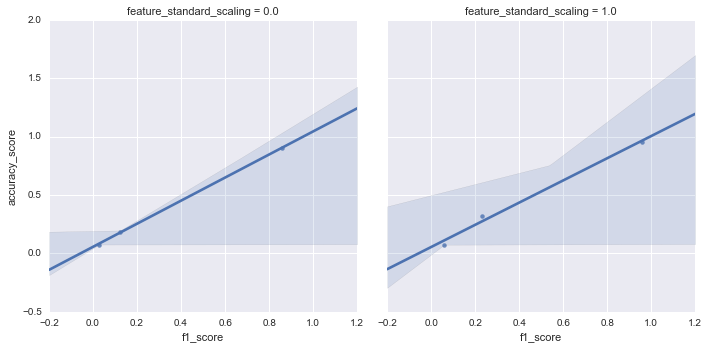

In [25]:
# this result seems to show that standard scaling the features
# does improve the SGD accuracy.
sns.lmplot("f1_score", "accuracy_score",
           results_df[results_df['classification'] == 'sgd'],
           col="feature_standard_scaling");

In [32]:
results_sorted_by_accuracy = re_index(results_df.sort_values('accuracy_score'))


In [34]:
results_sorted_by_accuracy['indx'] = results_sorted_by_accuracy.index

In [35]:
results_sorted_by_accuracy

,indx,feature_standard_scaling,label_col,classification,accuracy_score,f1_score,recall_score,precision_score
0,0,1,end_postal_code,sgd,0.075361,0.059486,0.075361,0.061977
1,1,0,end_postal_code,sgd,0.076430,0.027110,0.076430,0.022991
2,2,0,end_postal_code,lr,0.132549,0.058216,0.132549,0.049196
3,3,1,end_postal_code,lr,0.160342,0.083981,0.160342,0.094756
4,4,0,end_neighborhood,sgd,0.187296,0.123287,0.187296,0.120098
5,5,1,end_neighborhood,sgd,0.318132,0.229970,0.318132,0.376443
6,6,0,end_neighborhood,lr,0.400109,0.293629,0.400109,0.275040
7,7,1,end_neighborhood,lr,0.406623,0.301851,0.406623,0.396778
8,8,0,end_sublocality,sgd,0.903069,0.857073,0.903069,0.815534
9,9,0,end_sublocality,lr,0.952612,0.952955,0.952612,0.953891


In [ ]:
''' Comparing by accuracy score, predicting the 'end_sublocality' (a.k.a. borough) 
is the most reliable. And in most cases, feature standard scaling improves the SGD performance,
measuring by accuracy. But when it comes to predicting the neighborhood, although
both basic LR and SGD are doing pretty poorly around 40%, LR is doing much better than SGD here.
The note also is that SGD used here is w/o parameter tuning.
'''

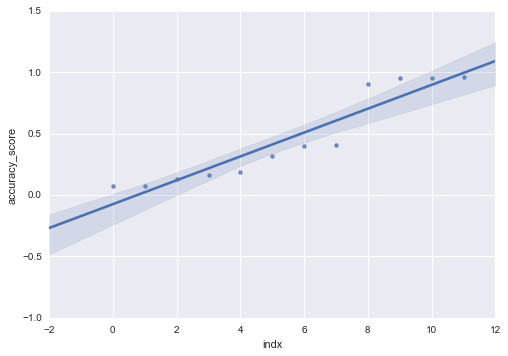

In [36]:
ax = sns.regplot(x='indx', y="accuracy_score", data=results_sorted_by_accuracy)

In [ ]:
'''
output data columns are : accuracy, f1 score, 

inputs are classification, feature scaling, 
'''

In [37]:
# after introducing 'sgd_grid' , rerunning the experiment ....




In [13]:
results = experiment_with_sgd(next_df)

starting num  0 {'feature_standard_scaling': 0, 'label_col': 'end_sublocality', 'classification': 'sgd_grid'}


/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
starting num  1 {'feature_standard_scaling': 0, 'label_col': 'end_sublocality', 'classification': 'lr'}


/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
starting num  2 {'feature_standard_scaling': 0, 'label_col': 'end_sublocality', 'classification': 'sgd'}


/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
starting num  3 {'feature_standard_scaling': 0, 'label_col': 'end_postal_code', 'classification': 'sgd_grid'}


/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from ve

couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
starting num  4 {'feature_standard_scaling': 0, 'label_col': 'end_postal_code', 'classification': 'lr'}


/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
starting num  5 {'feature_standard_scaling': 0, 'label_col': 'end_postal_code', 'classification': 'sgd'}


/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
starting num  6 {'feature_standard_scaling': 0, 'label_col': 'end_neighborhood', 'classification': 'sgd_grid'}


/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
starting num  7 {'feature_standard_scaling': 0, 'label_col': 'end_neighborhood', 'classification': 'lr'}


/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
starting num  8 {'feature_standard_scaling': 0, 'label_col': 'end_neighborhood', 'classification': 'sgd'}


/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
starting num  9 {'feature_standard_scaling': 1, 'label_col': 'end_sublocality', 'classification': 'sgd_grid'}


/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
starting num  10 {'feature_standard_scaling': 1, 'label_col': 'end_sublocality', 'classification': 'lr'}


/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
starting num  11 {'feature_standard_scaling': 1, 'label_col': 'end_sublocality', 'classification': 'sgd'}


/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
starting num  12 {'feature_standard_scaling': 1, 'label_col': 'end_postal_code', 'classification': 'sgd_grid'}


/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
starting num  13 {'feature_standard_scaling': 1, 'label_col': 'end_postal_code', 'classification': 'lr'}


/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
starting num  14 {'feature_standard_scaling': 1, 'label_col': 'end_postal_code', 'classification': 'sgd'}


/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
starting num  15 {'feature_standard_scaling': 1, 'label_col': 'end_neighborhood', 'classification': 'sgd_grid'}


/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
starting num  16 {'feature_standard_scaling': 1, 'label_col': 'end_neighborhood', 'classification': 'lr'}


/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
starting num  17 {'feature_standard_scaling': 1, 'label_col': 'end_neighborhood', 'classification': 'sgd'}
couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified
couldnt run metrik  <function roc_curve at 0x10b098b18>  =>  Data is not binary and pos_label is not specified


/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted"

In [14]:
len(results)

18

In [16]:
results2_df = _df_from_results(results)

In [17]:
results2_df.head()

,indx,feature_standard_scaling,label_col,classification,accuracy_score,f1_score,recall_score,precision_score
0,0,0,end_sublocality,sgd_grid,0.812601,0.841883,0.812601,0.884189
1,1,0,end_sublocality,lr,0.949919,0.944569,0.949919,0.940708
2,2,0,end_sublocality,sgd,0.916532,0.876616,0.916532,0.840031
3,3,0,end_postal_code,sgd_grid,0.068413,0.009632,0.068413,0.006215
4,4,0,end_postal_code,lr,0.125601,0.055104,0.125601,0.045031


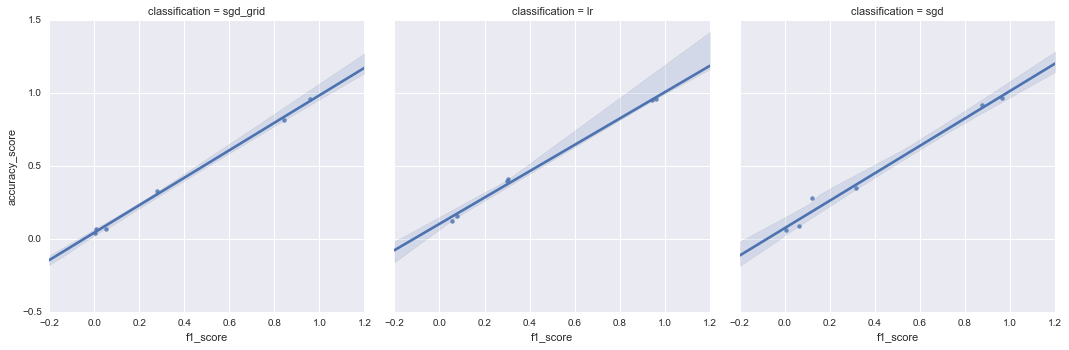

In [19]:
# see how sgd_grid compares in general, along accuracy, 
sns.lmplot("f1_score", "accuracy_score",
           results2_df,
           col="classification");

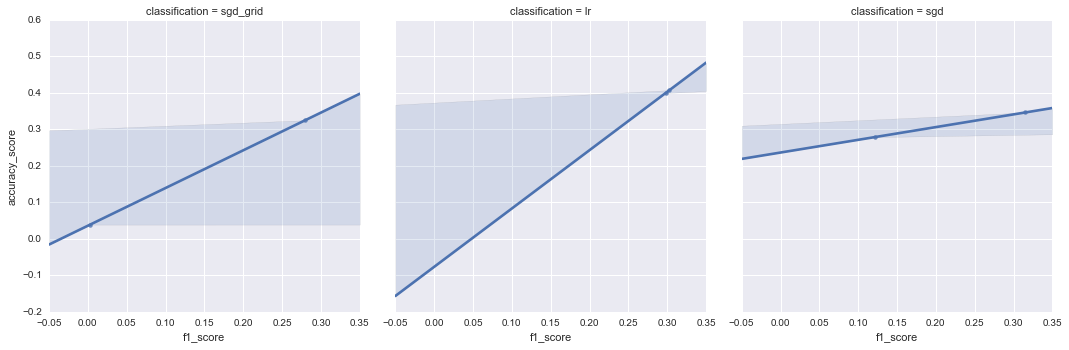

In [30]:
# see how sgd_grid compares in general, along accuracy, 
sns.lmplot("f1_score", "accuracy_score",
           results2_df[results2_df['label_col'] == 'end_neighborhood'],
           col="classification");

In [35]:
results2_sorted_by_accuracy = re_index(results2_df.sort_values('accuracy_score'))
results2_sorted_by_accuracy['indx'] = results2_sorted_by_accuracy.index


###### looking at some of latest sgd_grid results
Very strange that sgd with more optimized alpha has worse performance that sgd using some randomly chosen alpha. That doesnt make much sense yet. There might be an error in useage somewhere.

In [36]:
results2_sorted_by_accuracy

,indx,feature_standard_scaling,label_col,classification,accuracy_score,f1_score,recall_score,precision_score
0,0,0,end_neighborhood,sgd_grid,0.039088,0.002941,0.039088,0.001528
1,1,0,end_postal_code,sgd,0.059327,0.006645,0.059327,0.003520
2,2,1,end_postal_code,sgd_grid,0.065206,0.050477,0.065206,0.082727
3,3,0,end_postal_code,sgd_grid,0.068413,0.009632,0.068413,0.006215
4,4,1,end_postal_code,sgd,0.087654,0.064523,0.087654,0.088158
5,5,0,end_postal_code,lr,0.125601,0.055104,0.125601,0.045031
6,6,1,end_postal_code,lr,0.155532,0.077763,0.155532,0.079457
7,7,0,end_neighborhood,sgd,0.279045,0.121808,0.279045,0.077908
8,8,1,end_neighborhood,sgd_grid,0.325190,0.279774,0.325190,0.265358
9,9,1,end_neighborhood,sgd,0.346363,0.314855,0.346363,0.313023


In [37]:
results2_sorted_by_precision = re_index(results2_df.sort_values('accuracy_score'))
results2_sorted_by_precision['indx'] = results2_sorted_by_precision.index



In [ ]:
# Also, other basic metrics follow accuracy here for the different pipeline setups.

In [38]:
results2_sorted_by_precision

,indx,feature_standard_scaling,label_col,classification,accuracy_score,f1_score,recall_score,precision_score
0,0,0,end_neighborhood,sgd_grid,0.039088,0.002941,0.039088,0.001528
1,1,0,end_postal_code,sgd,0.059327,0.006645,0.059327,0.003520
2,2,1,end_postal_code,sgd_grid,0.065206,0.050477,0.065206,0.082727
3,3,0,end_postal_code,sgd_grid,0.068413,0.009632,0.068413,0.006215
4,4,1,end_postal_code,sgd,0.087654,0.064523,0.087654,0.088158
5,5,0,end_postal_code,lr,0.125601,0.055104,0.125601,0.045031
6,6,1,end_postal_code,lr,0.155532,0.077763,0.155532,0.079457
7,7,0,end_neighborhood,sgd,0.279045,0.121808,0.279045,0.077908
8,8,1,end_neighborhood,sgd_grid,0.325190,0.279774,0.325190,0.265358
9,9,1,end_neighborhood,sgd,0.346363,0.314855,0.346363,0.313023


In [39]:
# 
# using more data in the pipeline... 
# currently using 'data/201510-citibike-tripdata.csv.annotated.mini.02212016T1641.csv' 
# which has data prepared earlier. 
